**Energy Consumption¶**

To better follow the energy consumption, the government wants energy suppliers to install smart meters in every home in England, Wales and Scotland. There are more than 26 million homes for the energy suppliers to get to, with the goal of every home having a smart meter by 2020.

This roll out of meter is lead by the European Union who asked all member governments to look at smart meters as part of measures to upgrade our energy supply and tackle climate change. After an initial study, the British government decided to adopt smart meters as part of their plan to update our ageing energy system.

In this dataset, you will find a refactorised version of the data from the London data store, that contains the energy consumption readings for a sample of 5,567 London Households that took part in the UK Power Networks led Low Carbon London project between November 2011 and February 2014. The data from the smart meters seems associated only to the electrical consumption.

**Approach :**

1.Combine all blocks into a single dataframe- keeping on relevant columns.

2.Use day-level energy consumption data per household to normalize data for inconsistent household count

3.Explore relationships between weather conditions and energy consumptions. Create clusters for the weather data- using which we can add weather identifiers to day-level data

4.Add UK holidays data to the day level data as an indicator.

5.Fit an ARIMA model

 i) ACF, PACF

 ii) Explore Seasonal Decomposition

 iii) Modelling

6.Fit an LSTM model

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.0 MB/s eta 0:00:00


In [ ]:
import zipfile
import os

# Replace 'archive.zip' with the exact name if different
with zipfile.ZipFile("smart_meter_data.zip", 'r') as zip_ref:
    zip_ref.extractall("extracted_data")

# List extracted files
os.listdir("extracted_data")

['daily_dataset',
 'weather_hourly_darksky.csv',
 'informations_households.csv',
 'acorn_details.csv',
 'darksky_parameters_documentation.html',
 'hhblock_dataset',
 'daily_dataset.csv',
 'weather_daily_darksky.csv',
 'uk_bank_holidays.csv',
 'halfhourly_dataset']

In [ ]:
! pip install keras  # "Python Machine Learning ARIMA". It is used for time series forecasting.

# **Daily Energy Data**

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import os

from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
#from pandas.tools.plotting import autocorrelation_plot # Old import
from pandas.plotting import autocorrelation_plot # New import

#from pyramid.arima import auto_arima
#from pmdarima.arima import auto_arima

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

We are predicting for energy demand in the future- therefore we are taking only energy sum i.e. total energy use per day for a given household.




In [ ]:
import pandas as pd
import os

# First, let's verify the correct path structure
base_path = "/content/extracted_data/daily_dataset/daily_dataset/"
print(f"Checking files in: {base_path}")
print("Sample files found:", [f for f in os.listdir(base_path) if f.startswith('block_')][:5])

# Initialize an empty list to store all DataFrames
all_dfs = []

# Loop through files block_1.csv to block_111.csv
for num in range(1, 112):  # Changed range to 1-111
    file_path = f"{base_path}block_{num}.csv"  # Single underscore

    try:
        df = pd.read_csv(file_path)
        df = df[['day', 'LCLid', 'energy_sum']]  # Select needed columns
        all_dfs.append(df)
        print(f"Processed block_{num}.csv successfully")
    except FileNotFoundError:
        print(f"Warning: File block_{num}.csv not found, skipping")
    except Exception as e:
        print(f"Error processing block_{num}.csv: {str(e)}")

# Combine all DataFrames at once (more efficient than writing line by line)
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)

    # Save to a single CSV
    combined_df.to_csv("energy.csv", index=False)
    print("Successfully combined all files into energy.csv")
    print(f"Final DataFrame shape: {combined_df.shape}")
else:
    print("No files were processed. Please check the input directory.")

Checking files in: /content/extracted_data/daily_dataset/daily_dataset/
Sample files found: ['block_55.csv', 'block_107.csv', 'block_54.csv', 'block_100.csv', 'block_92.csv']
Processed block_1.csv successfully
Processed block_2.csv successfully
Processed block_3.csv successfully
Processed block_4.csv successfully
Processed block_5.csv successfully
Processed block_6.csv successfully
Processed block_7.csv successfully
Processed block_8.csv successfully
Processed block_9.csv successfully
Processed block_10.csv successfully
Processed block_11.csv successfully
Processed block_12.csv successfully
Processed block_13.csv successfully
Processed block_14.csv successfully
Processed block_15.csv successfully
Processed block_16.csv successfully
Processed block_17.csv successfully
Processed block_18.csv successfully
Processed block_19.csv successfully
Processed block_20.csv successfully
Processed block_21.csv successfully
Processed block_22.csv successfully
Processed block_23.csv successfully
Proces

## **Day Level Energy**

In [ ]:
energy = pd.read_csv('energy.csv')
len(energy)

3484859

In [ ]:
housecount = energy.groupby('day')[['LCLid']].nunique()
housecount.head(4)   # LCLid : Each household that participated in the Low Carbon London project (2011–2014) was assigned a unique ID.

,LCLid
day,
2011-11-23,13
2011-11-24,25
2011-11-25,32
2011-11-26,41


**House Count**

In the dataset we see that the number of households for which energy data was collected across different days are different. This is probably due to the gradually increasing adoption of smart meters in London. This could lead to false interpretation that the energy for a particular day might be high when it could be that the data was only collected for more number of houses. We will look at the house count for each day.

<Axes: xlabel='day'>

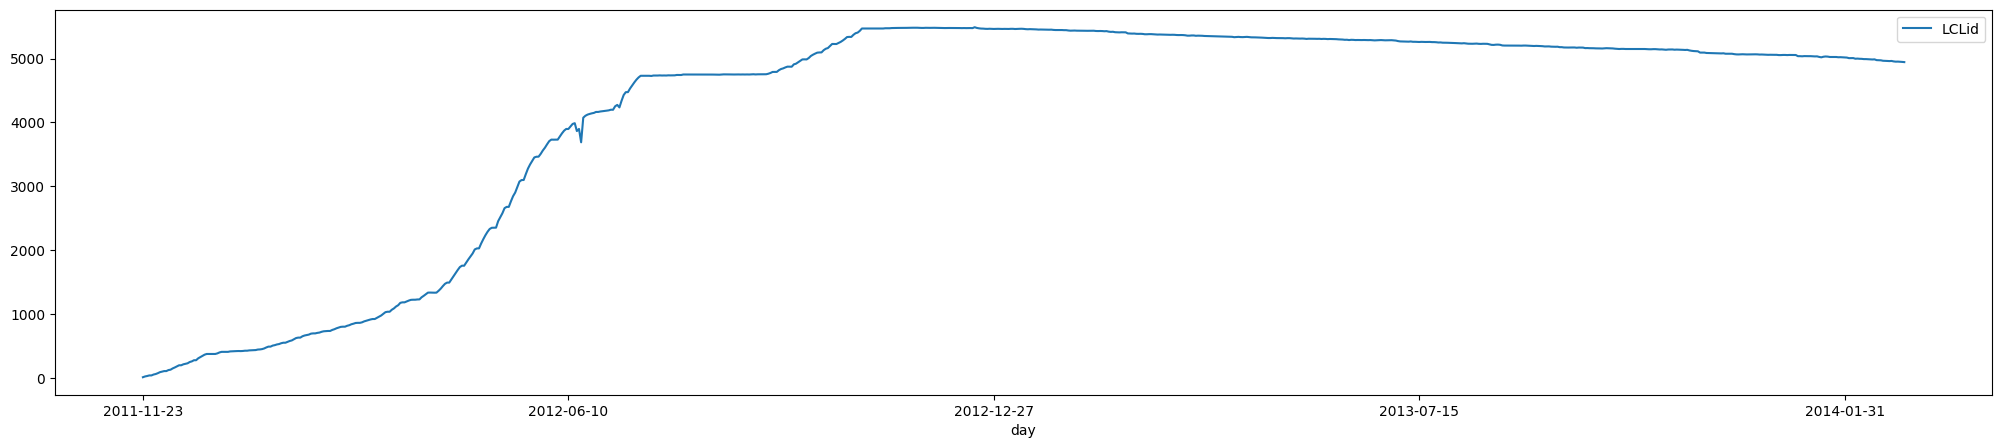

In [ ]:
housecount.plot(figsize=(25,5))

**Normalization across households**

The data collection across households are inconsistent- therefore we will be using energy per household as the target to predict rather than energy alone. This is an optional step as we can also predict for energy sum as whole for each household. However there are quite a lot of unique households for which we have to repeat the exercise and our ultimate goal is to predict overall consumption forecast and not at household level.
This also means that since household level is removed, we are not looking into the ACORN details which is available at household level

In [ ]:
energy = energy.groupby('day')[['energy_sum']].sum()
energy = energy.merge(housecount, on = ['day'])
energy = energy.reset_index()

In [ ]:
energy.count()

,0
day,829
energy_sum,829
LCLid,829


In [ ]:
energy.day = pd.to_datetime(energy.day,format='%Y-%m-%d').dt.date

In [ ]:
energy['avg_energy'] =  energy['energy_sum']/energy['LCLid']
print("Starting Point of Data at Day Level",min(energy.day))
print("Ending Point of Data at Day Level",max(energy.day))

Starting Point of Data at Day Level 2011-11-23
Ending Point of Data at Day Level 2014-02-28


In [ ]:
energy.describe()

,energy_sum,LCLid,avg_energy
count,829.000000,829.000000,829.000000
mean,42206.105703,4203.689988,10.289902
std,19732.969970,1773.087516,1.884036
min,90.385000,13.000000,0.207979
25%,34172.738998,4075.000000,8.508883
50%,45090.958005,5094.000000,10.267707
75%,57789.601009,5320.000000,11.759530
max,81144.849003,5491.000000,15.941186


**Weather Information¶**

Daily level weather information is taken using darksky api in the dataset

In [ ]:
weather = pd.read_csv('/content/extracted_data/weather_daily_darksky.csv')
weather.head(4)

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,...,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,...,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,...,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,...,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25


In [ ]:
weather.describe()

,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
count,882.000000,882.000000,882.000000,881.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,881.000000,882.000000,882.000000,882.000000,882.000000,882.000000
mean,13.660113,195.702948,6.530034,0.477605,3.581803,1014.127540,12.723866,11.167143,0.781871,6.085045,12.929467,2.542565,7.709841,7.414161,13.542392,5.738039,0.500930
std,6.182744,89.340783,4.830875,0.193514,1.694007,11.073038,7.279168,2.466109,0.095348,6.031967,7.105426,1.832985,4.871004,4.888852,6.260196,6.048746,0.287022
min,-0.060000,0.000000,-7.840000,0.000000,0.200000,979.250000,-6.460000,1.480000,0.430000,-8.880000,-4.110000,0.000000,-5.640000,-5.640000,-0.810000,-8.880000,0.000000
25%,9.502500,120.500000,3.180000,0.350000,2.370000,1007.435000,7.032500,10.327500,0.720000,1.522500,7.332500,1.000000,3.990000,3.705000,9.212500,1.105000,0.260000
50%,12.625000,219.000000,6.380000,0.470000,3.440000,1014.615000,12.470000,11.970000,0.790000,5.315000,12.625000,2.000000,7.540000,7.100000,12.470000,4.885000,0.500000
75%,17.920000,255.000000,10.057500,0.600000,4.577500,1021.755000,17.910000,12.830000,0.860000,11.467500,17.920000,4.000000,11.467500,11.277500,17.910000,11.277500,0.750000
max,32.400000,359.000000,17.770000,1.000000,9.960000,1040.920000,32.420000,15.340000,0.980000,20.540000,32.420000,7.000000,20.540000,20.540000,32.400000,20.540000,0.990000


In [ ]:
weather['day']=  pd.to_datetime(weather['time']) # day is given as timestamp
weather['day']=  pd.to_datetime(weather['day'],format='%Y%m%d').dt.date
# selecting numeric variables
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day']]
weather = weather.dropna()

In [ ]:
weather_energy =  energy.merge(weather,on='day')
weather_energy.head(2)

,day,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,...,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
0,2011-11-23,90.385,13,6.952692,10.36,229,6.29,0.36,2.04,1027.12,...,8.06,0.93,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94
1,2011-11-24,213.412,25,8.536480,12.93,204,8.56,0.41,4.04,1027.22,...,10.64,0.89,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97


**1. Temperature**

We can see that **energy and temperature have an inverse relationship**-we can see the peaks in one appearing with troughs in the other. This confirms the business intuition that during low temperature, it is likely that the energy consumption through heaters etc. increases.

<ipython-input-18-2515040149>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
<ipython-input-18-2515040149>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))


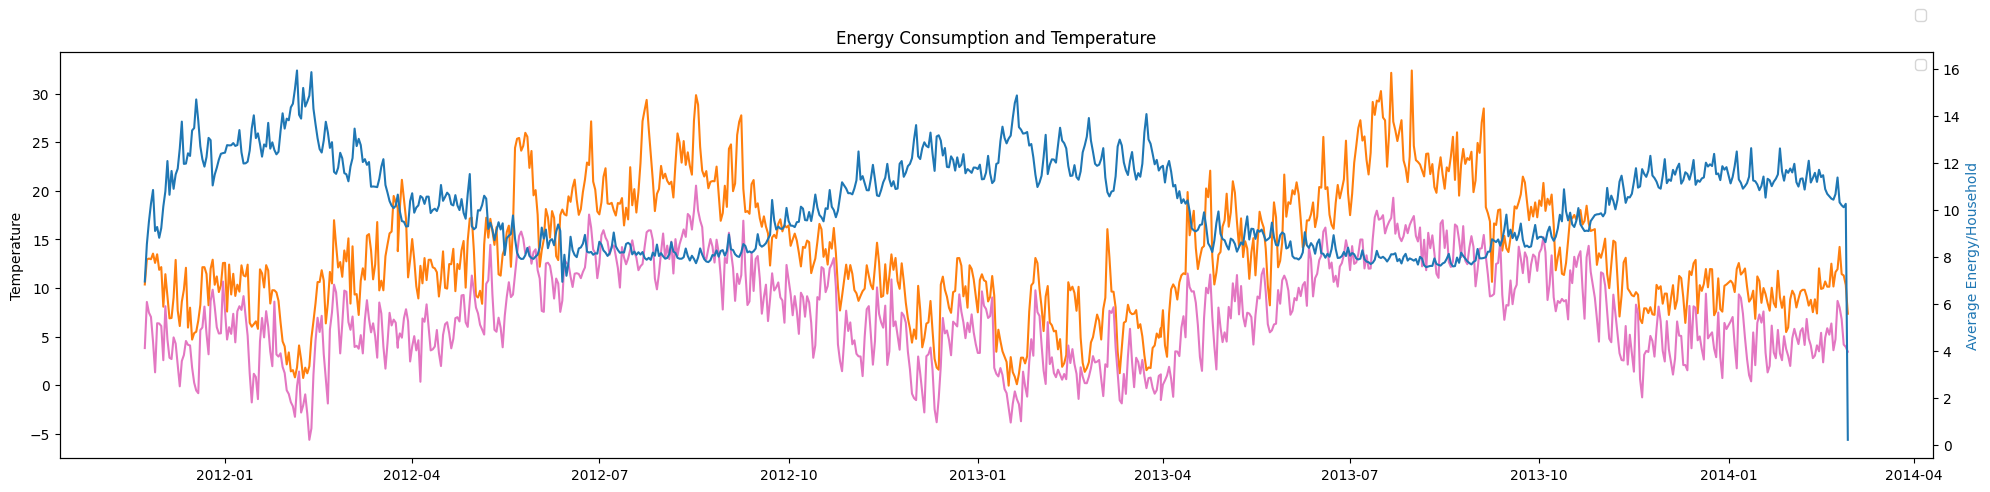

In [ ]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.temperatureMax, color = 'tab:orange')
ax1.plot(weather_energy.day, weather_energy.temperatureMin, color = 'tab:pink')
ax1.set_ylabel('Temperature')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()

Orange & Pink Lines → temperatureMax and temperatureMin

Blue Line → avg_energy per household

X-axis → Dates (from 2011 to 2014)

This lets you visually compare how energy usage reacts to temperature changes.

**2. Humidity**

Humidity and the average consumption of energy seems to have the same trend.

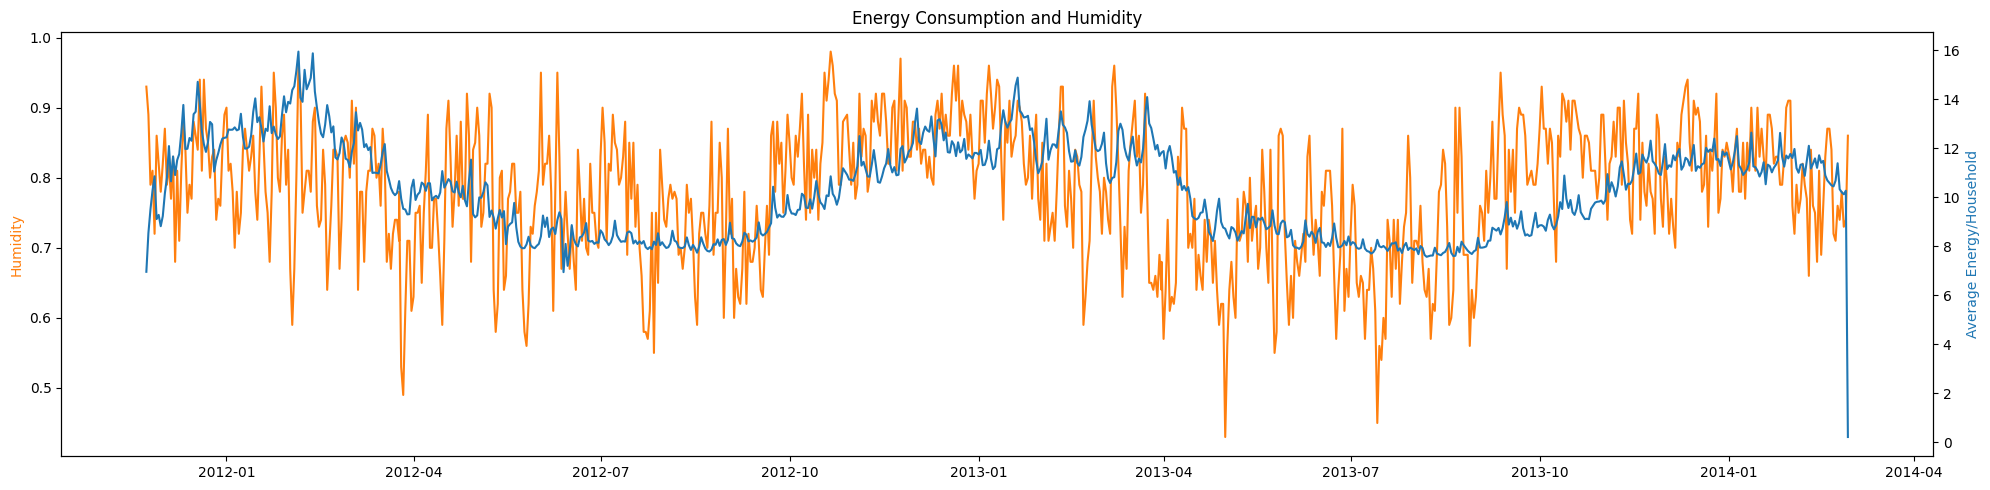

In [ ]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.humidity, color = 'tab:orange')
ax1.set_ylabel('Humidity',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Humidity')
fig.tight_layout()
plt.show()

Orange line = Humidity over time

Blue line = Average energy usage per household over the same period

X-axis = Date (from 2011 to 2014)

**3. Cloud Cover**

The cloud cover value seems to be following the same pattern as the energy consumption.

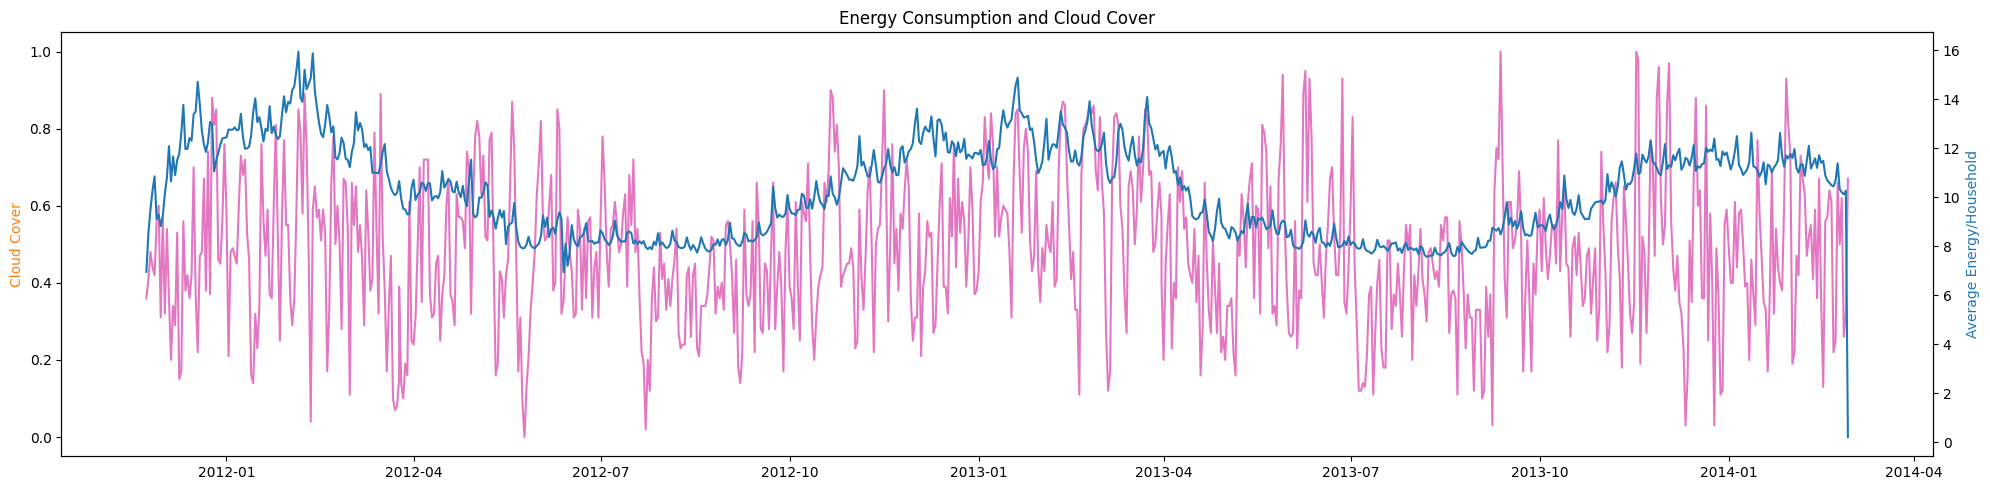

In [ ]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.cloudCover, color = 'tab:pink')
ax1.set_ylabel('Cloud Cover',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Cloud Cover')
fig.tight_layout()
plt.show()

Pink line = Cloud Cover (e.g., overcast or clear days)

**4. Visibility**

The visibility factor does not seem to affect energy consumption at all- since visibility is most likely an outdoors factor, it is unlikely that it's increase or decrease affects energy consumption within a household.

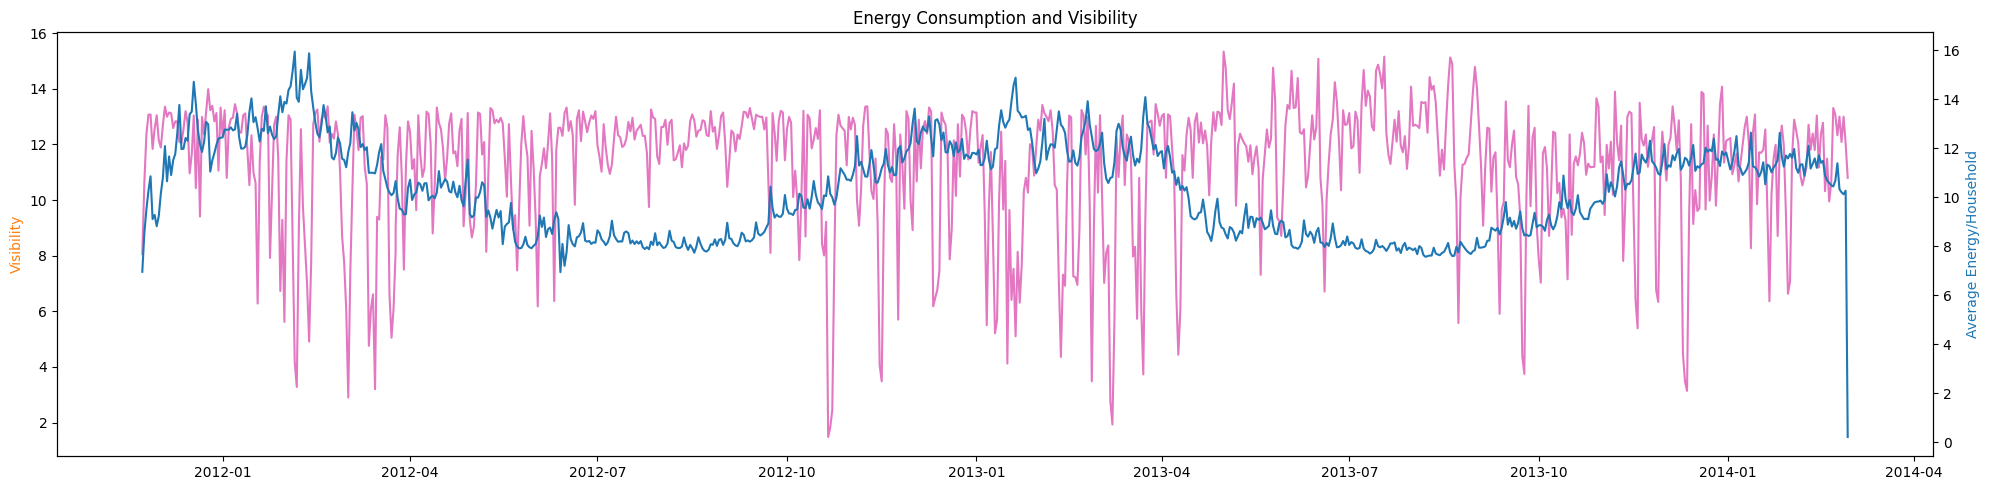

In [ ]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.visibility, color = 'tab:pink')
ax1.set_ylabel('Visibility',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Visibility')
fig.tight_layout()
plt.show()

Pink line → Visibility

**5. Wind Speed**

Like visibility, wind speed seems to be an outdoors factor which does not affect in the energy consumption as such.

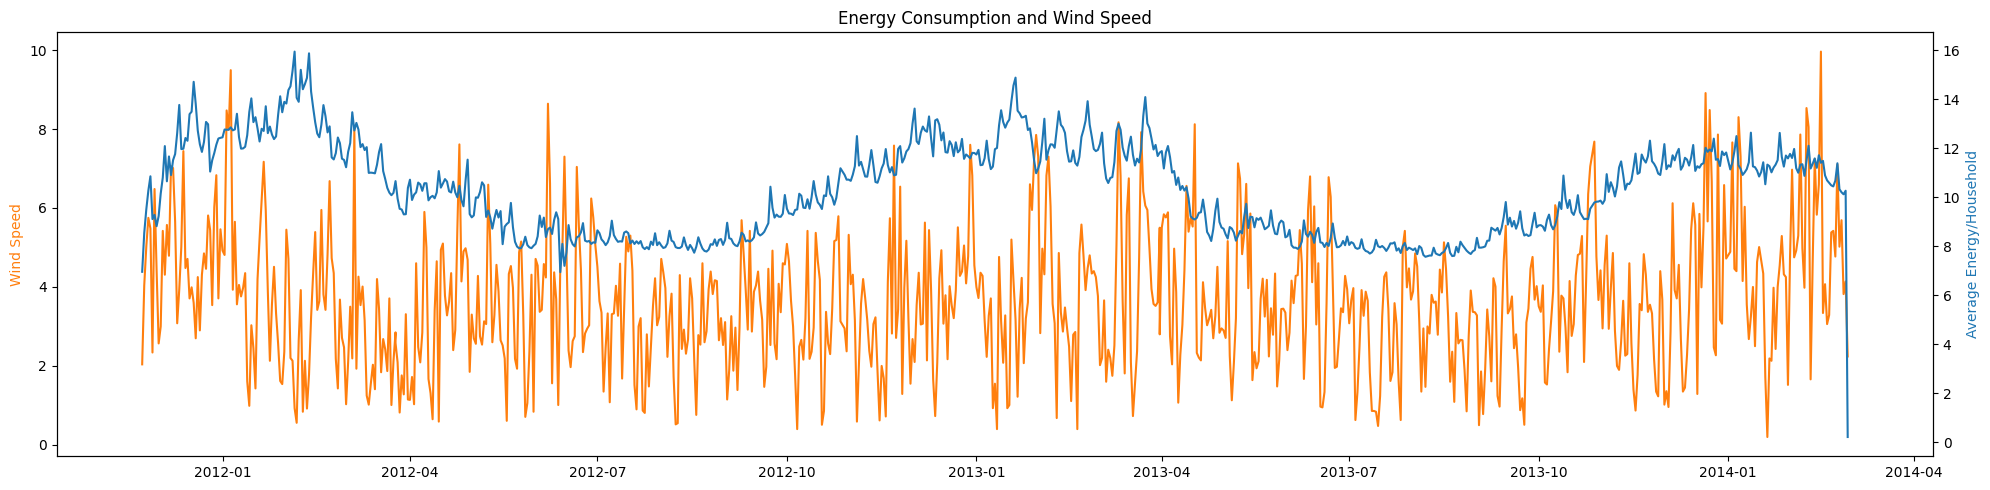

In [ ]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.windSpeed, color = 'tab:orange')
ax1.set_ylabel('Wind Speed',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Wind Speed')
fig.tight_layout()
plt.show()

Orange Line → Wind speed over time

**6. UV Index**

The UV index has an inverse relationship with energy consumption- why?

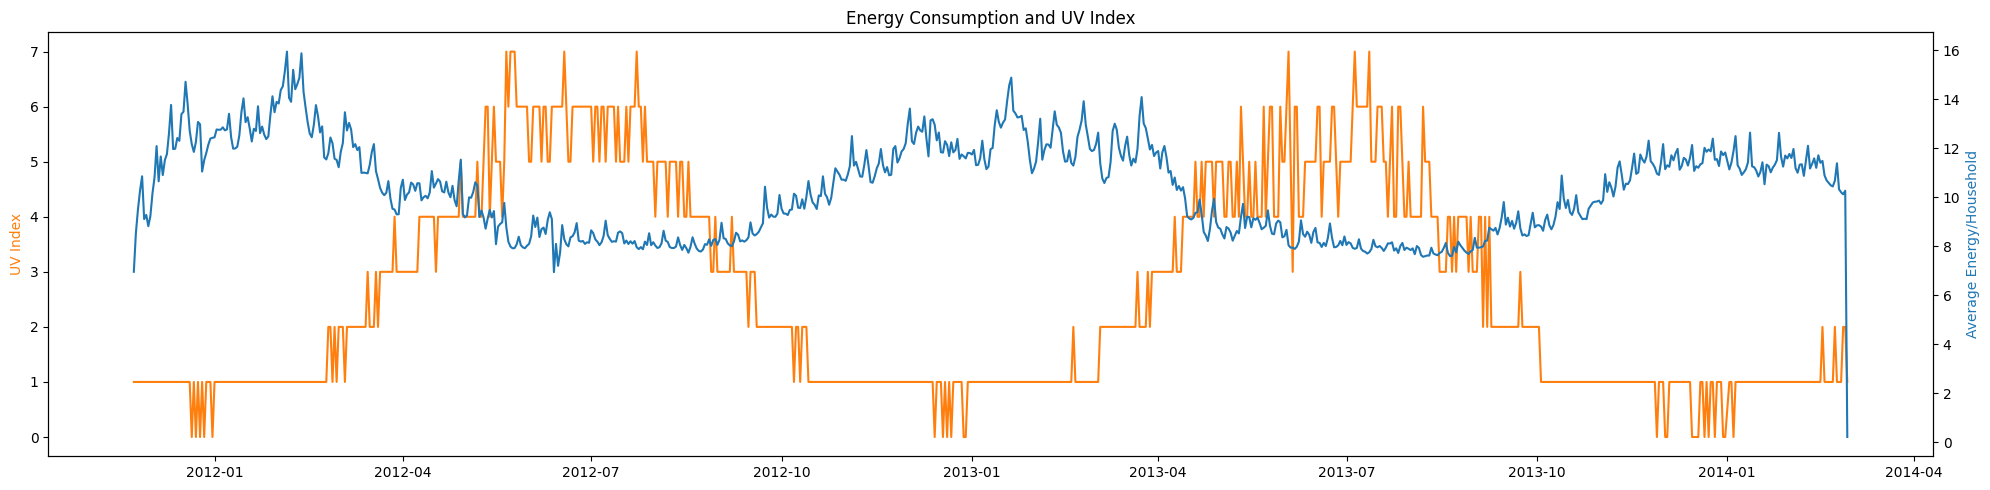

In [ ]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.uvIndex, color = 'tab:orange')
ax1.set_ylabel('UV Index',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and UV Index')
fig.tight_layout()
plt.show()

Orange line → UV Index

**7. dewPoint**

Dew Point- is a function of humidity and temperature therefore it displays similar relation to energy consumption.

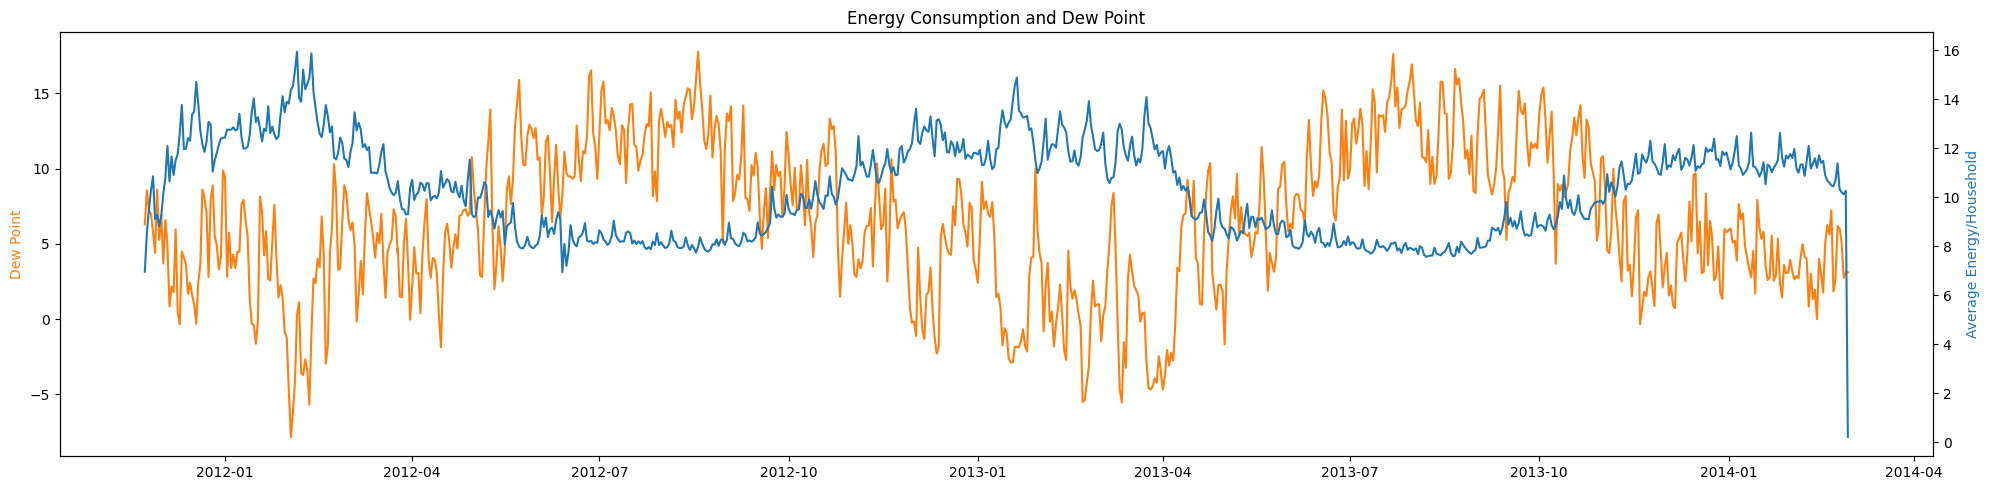

In [ ]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.dewPoint, color = 'tab:orange')
ax1.set_ylabel('Dew Point',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Dew Point')
fig.tight_layout()
plt.show()

Orange line → Dew Point over time

Correlation between Weather Variables and Energy Consumption¶

1.Energy has high positive correlation with humidity and high negative correlation with temperature.

2.Dew Point, UV Index display multicollinearity with Temperature, hence discarded

3.Cloud Cover and Visibility display multicollinearity with Humidity, hence discarded

4.Pressure and Moon Phase have minimal correlation with Energy, hence discarded

5.Wind Speed has low correlation with energy but does not show multicollinearity

In [ ]:
cor_matrix = weather_energy[['avg_energy','temperatureMax','dewPoint', 'cloudCover', 'windSpeed','pressure', 'visibility', 'humidity','uvIndex', 'moonPhase']].corr()
cor_matrix

,avg_energy,temperatureMax,dewPoint,cloudCover,windSpeed,pressure,visibility,humidity,uvIndex,moonPhase
avg_energy,1.000000,-0.840765,-0.751709,0.238361,0.147459,-0.011863,-0.241867,0.356112,-0.724259,-0.031223
temperatureMax,-0.840765,1.000000,0.865038,-0.333409,-0.153602,0.118933,0.259108,-0.404899,0.696497,0.003636
dewPoint,-0.751709,0.865038,1.000000,-0.025207,-0.092212,-0.028121,0.042633,0.055514,0.486692,-0.008239
cloudCover,0.238361,-0.333409,-0.025207,1.000000,0.170235,-0.101079,-0.330177,0.480056,-0.248695,-0.062126
windSpeed,0.147459,-0.153602,-0.092212,0.170235,1.000000,-0.344354,0.281088,-0.042391,-0.152634,-0.023273
pressure,-0.011863,0.118933,-0.028121,-0.101079,-0.344354,1.000000,-0.012508,-0.250941,0.100774,0.038462
visibility,-0.241867,0.259108,0.042633,-0.330177,0.281088,-0.012508,1.000000,-0.578130,0.240485,0.062813
humidity,0.356112,-0.404899,0.055514,0.480056,-0.042391,-0.250941,-0.578130,1.000000,-0.533919,-0.013997
uvIndex,-0.724259,0.696497,0.486692,-0.248695,-0.152634,0.100774,0.240485,-0.533919,1.000000,0.012833
moonPhase,-0.031223,0.003636,-0.008239,-0.062126,-0.023273,0.038462,0.062813,-0.013997,0.012833,1.000000


**Creating Weather Clusters¶**

The weather information has a lot of variables - which might not all be useful. We will attempt to create weather clusters to see if we can define a weather of the day based on the granular weather data like temperature, precipitation etc.

In [ ]:
#scaling
scaler = MinMaxScaler()
weather_scaled = scaler.fit_transform(weather_energy[['temperatureMax','humidity','windSpeed']])

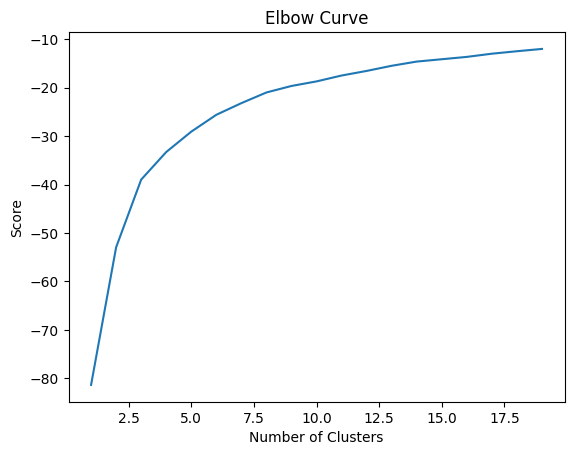

In [ ]:
# optimum K
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(weather_scaled).score(weather_scaled) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [ ]:
from sklearn.cluster import KMeans

# Change 'auto' to 'lloyd' or 'elkan', or remove the parameter to use the default ('lloyd')
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm='lloyd') # Or algorithm='elkan' or remove algorithm parameter
kmeans.fit(weather_scaled)
weather_energy['weather_cluster'] = kmeans.labels_

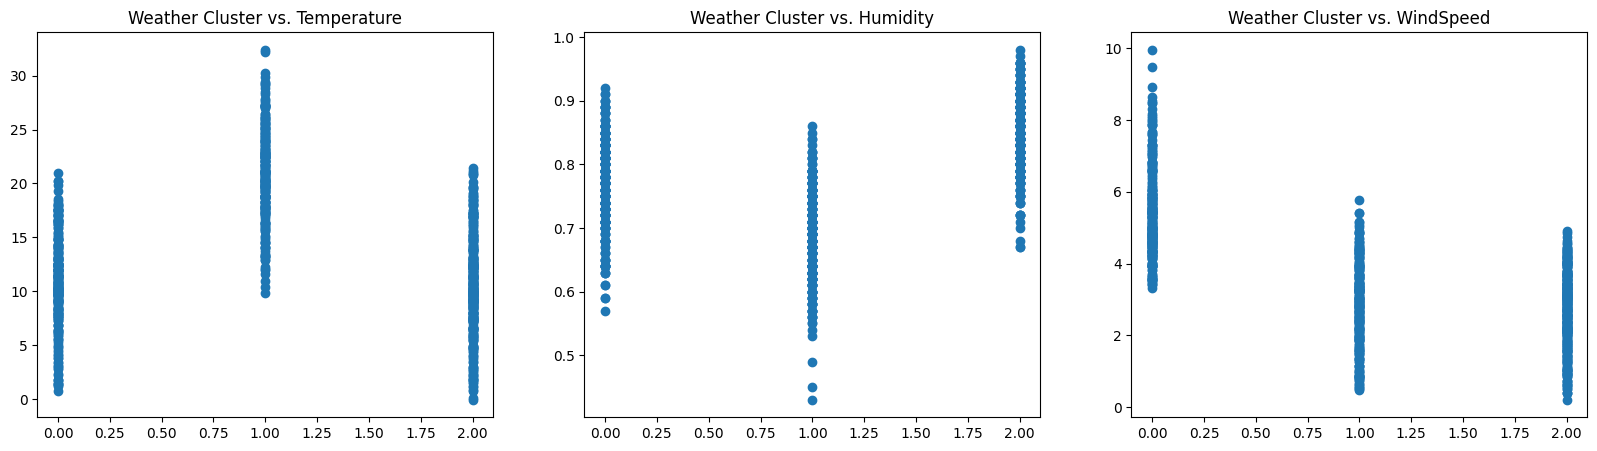

In [ ]:
# Cluster Relationships with weather variables
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.scatter(weather_energy.weather_cluster,weather_energy.temperatureMax)
plt.title('Weather Cluster vs. Temperature')
plt.subplot(1, 3, 2)
plt.scatter(weather_energy.weather_cluster,weather_energy.humidity)
plt.title('Weather Cluster vs. Humidity')
plt.subplot(1, 3, 3)
plt.scatter(weather_energy.weather_cluster,weather_energy.windSpeed)
plt.title('Weather Cluster vs. WindSpeed')

plt.show()
# put this in a loop

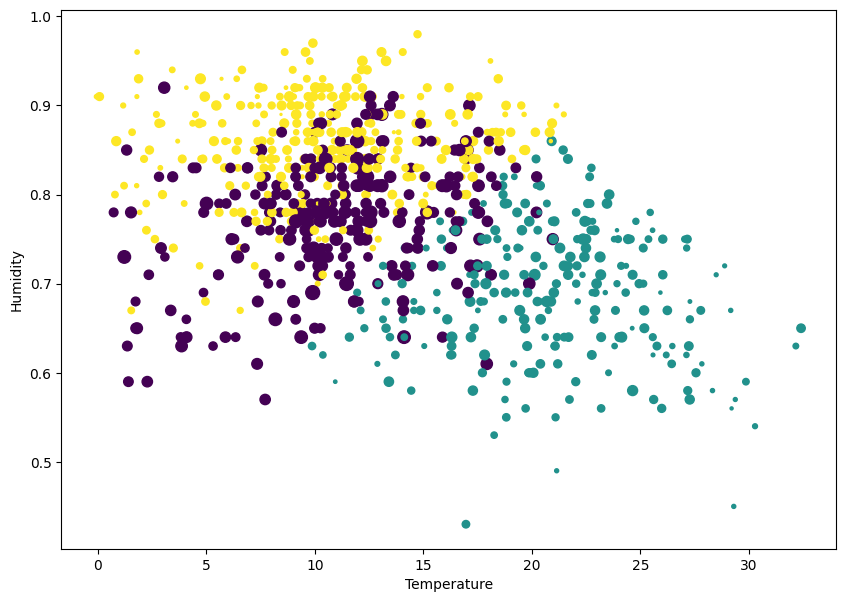

In [ ]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.scatter(weather_energy.temperatureMax,
            weather_energy.humidity,
            s = weather_energy.windSpeed*10,
            c = weather_energy.weather_cluster)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Humidity')
plt.show()

## **UK Bank Holidays¶**

In [ ]:
holiday = pd.read_csv('/content/extracted_data/uk_bank_holidays.csv')
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'],format='%Y-%m-%d').dt.date
holiday.head(4)

,Bank holidays,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)


**Creating a holiday indicator on weather data**

In [ ]:
weather_energy = weather_energy.merge(holiday, left_on = 'day',right_on = 'Bank holidays',how = 'left')
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(),0,1)

## **ARIMAX**

In [ ]:
weather_energy['Year'] = pd.DatetimeIndex(weather_energy['day']).year
weather_energy['Month'] = pd.DatetimeIndex(weather_energy['day']).month
weather_energy.set_index(['day'],inplace=True)

In [ ]:
model_data = weather_energy[['avg_energy','weather_cluster','holiday_ind']]
# train = model_data.iloc[0:round(len(model_data)*0.90)]
# test = model_data.iloc[len(train)-1:]
train = model_data.iloc[0:(len(model_data)-30)]
test = model_data.iloc[len(train):(len(model_data)-1)]

<Axes: xlabel='day'>

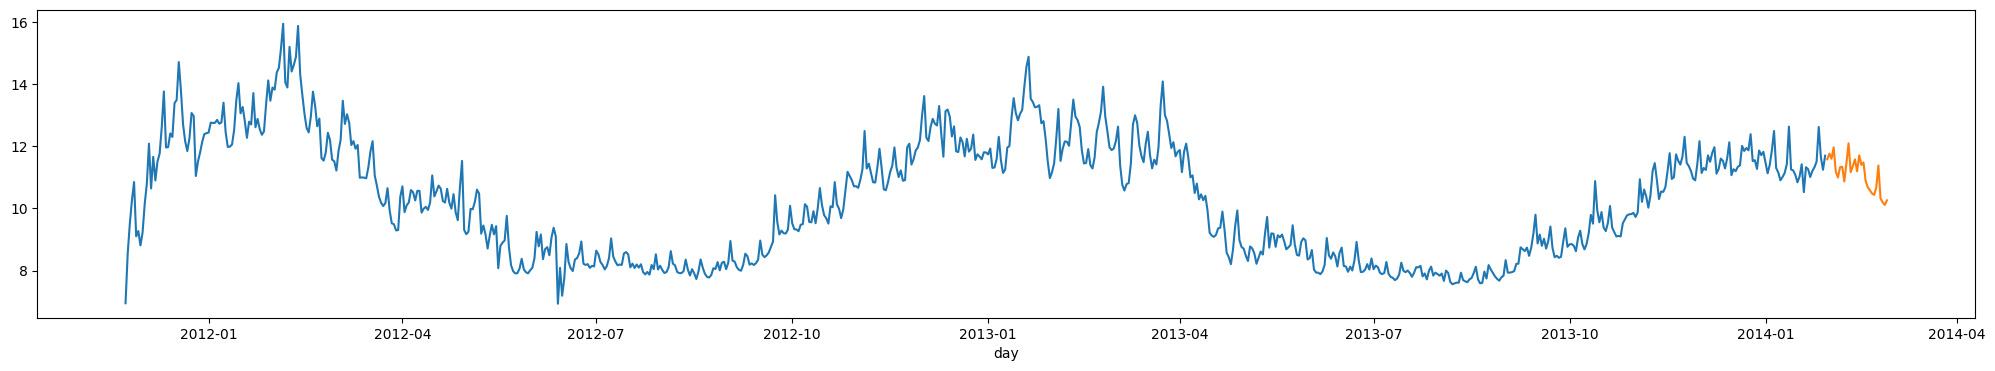

In [ ]:
train['avg_energy'].plot(figsize=(25,4))
test['avg_energy'].plot(figsize=(25,4))

In [ ]:
test.head(1)

,avg_energy,weather_cluster,holiday_ind
day,,,
2014-01-30,11.581719,2,0


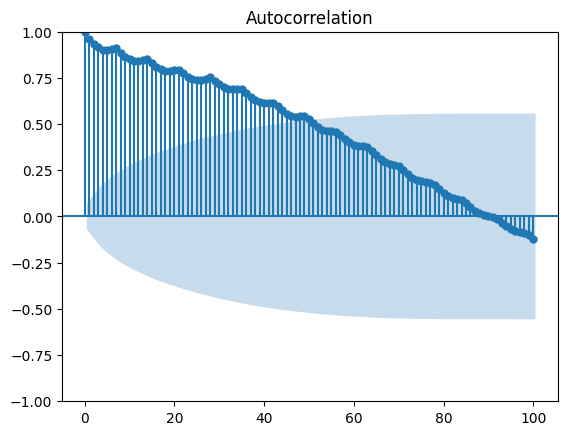

In [ ]:
plot_acf(train.avg_energy,lags=100)
plt.show()

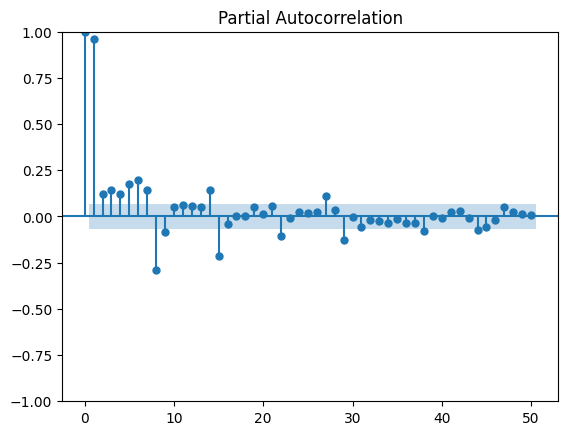

In [ ]:
plot_pacf(train.avg_energy,lags=50)
plt.show()

In [ ]:
t = sm.tsa.adfuller(train.avg_energy, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

,0
Test Statistic,-1.911717
p-value,0.326570
#Lags Used,21.000000
Number of Observations Used,776.000000


In [ ]:
# function for differencing
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [ ]:
t  = sm.tsa.adfuller(difference(train.avg_energy,1), autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

,0
Test Statistic,-6.737545e+00
p-value,3.179212e-09
#Lags Used,2.000000e+01
Number of Observations Used,7.760000e+02


**Seasonal Decomposition**

The seasonal component is quite low while the trend is quite strong with obvious dips in electricity consumption during summers i.e. April to September. This may be attributed to longer days during summer.

In [ ]:
s = sm.tsa.seasonal_decompose(train.avg_energy, period=12)

<Axes: xlabel='day'>

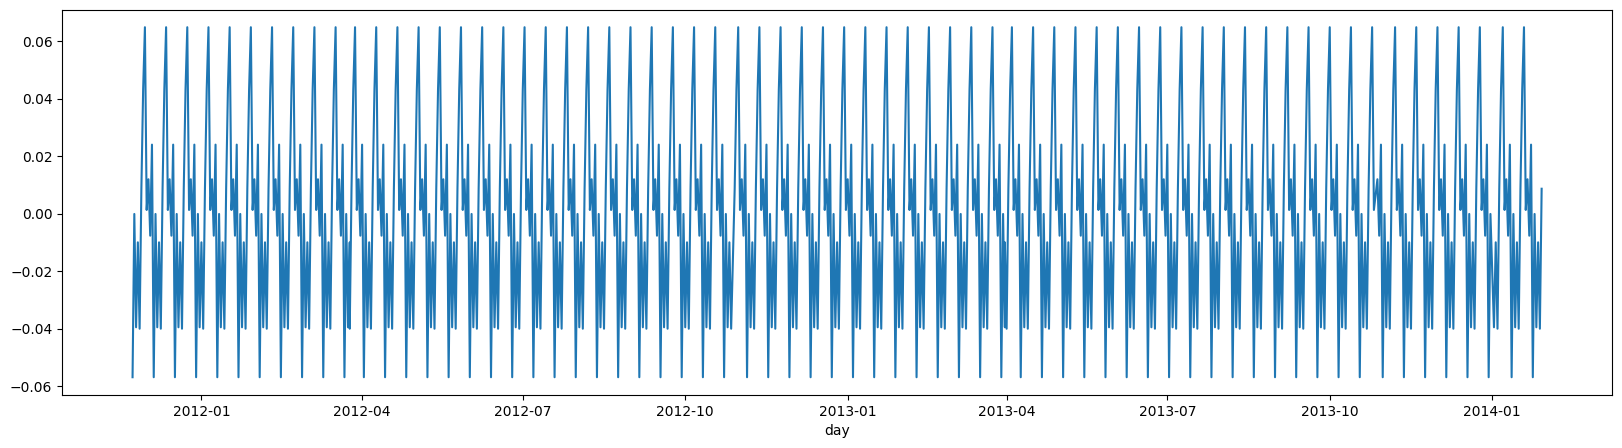

In [ ]:
s.seasonal.plot(figsize=(20,5))

<Axes: xlabel='day'>

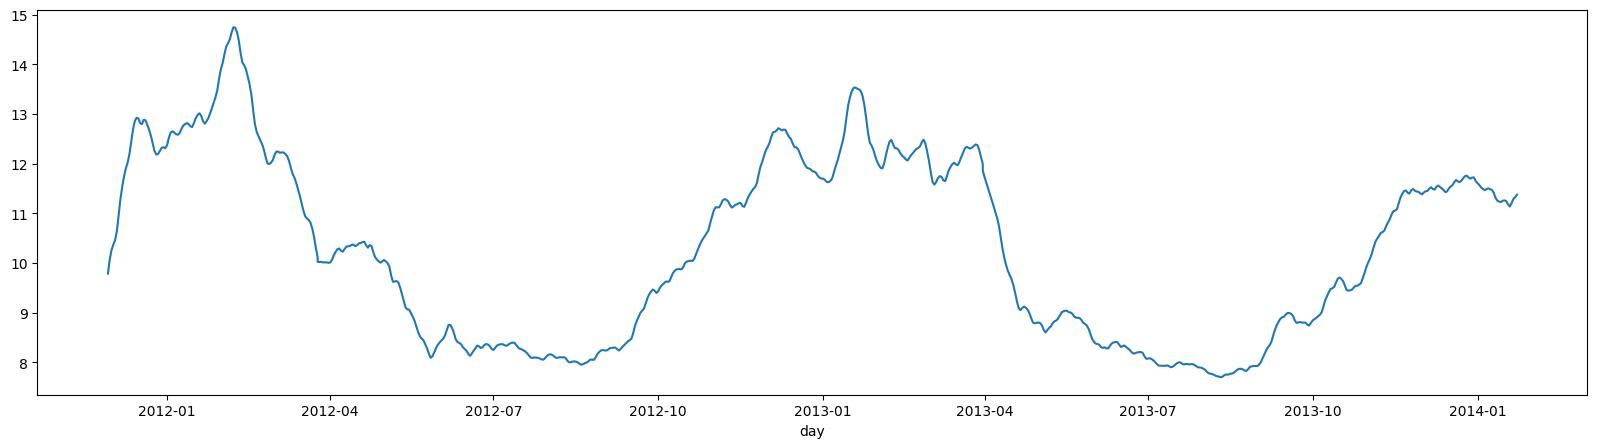

In [ ]:
s.trend.plot(figsize=(20,5))

<Axes: xlabel='day'>

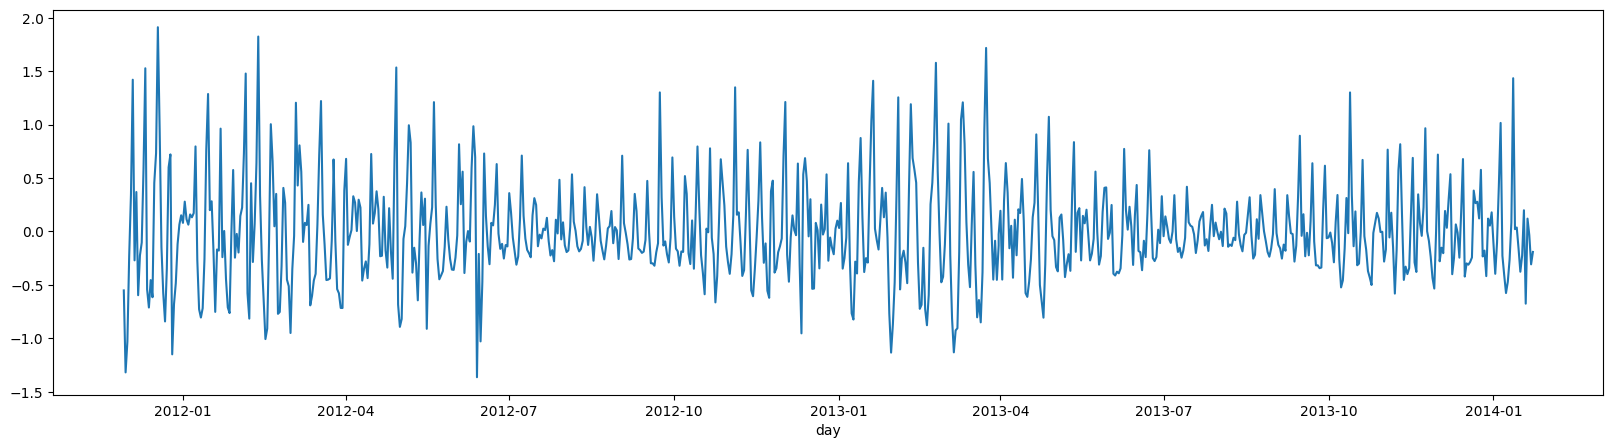

In [ ]:
s.resid.plot(figsize=(20,5))

In [ ]:
endog = train['avg_energy']
exog = sm.add_constant(train[['weather_cluster','holiday_ind']])

# Remove the trend='c' parameter as a constant is already included in exog
mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(7,1,1),seasonal_order=(1,1, 0, 12))
model_fit = mod.fit()
model_fit.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          avg_energy   No. Observations:                  798
Model:             SARIMAX(7, 1, 1)x(1, 1, [], 12)   Log Likelihood                -640.554
Date:                             Wed, 18 Jun 2025   AIC                           1307.108
Time:                                     09:27:32   BIC                           1367.762
Sample:                                          0   HQIC                          1330.429
                                             - 798                                         
Covariance Type:                               opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -2.264e-08   5.44e-10    -41.624      0.000   -2.37e-08   -2.16e-08
weather_cluster    -0.0034      0.016     -0.216      0.829      -0.035       0.028
holiday_ind        -0.0346      0.088     -0.395      0.693      -0.206       0.137
ar.L1              -0.0009      0.088     -0.011      0.992      -0.173       0.171
ar.L2              -0.1515      0.032     -4.714      0.000      -0.214      -0.089
ar.L3              -0.1411      0.038     -3.713      0.000      -0.216      -0.067
ar.L4              -0.1550      0.038     -4.083      0.000      -0.229      -0.081
ar.L5              -0.1569      0.040     -3.892      0.000      -0.236      -0.078
ar.L6               0.0076      0.036      0.210      0.833      -0.063       0.078
ar.L7               0.3482      0.028     12.277      0.000       0.293       0.404
ma.L1              -0.1851      0.093     -1.986      0.047      -0.368      -0.002
ar.S.L12           -0.4868      0.032    -15.036      0.000      -0.550      -0.423
sigma2              0.2974      0.012     24.496      0.000       0.274       0.321
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                53.72
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.24e+24. Standard errors may be unstable.
"""

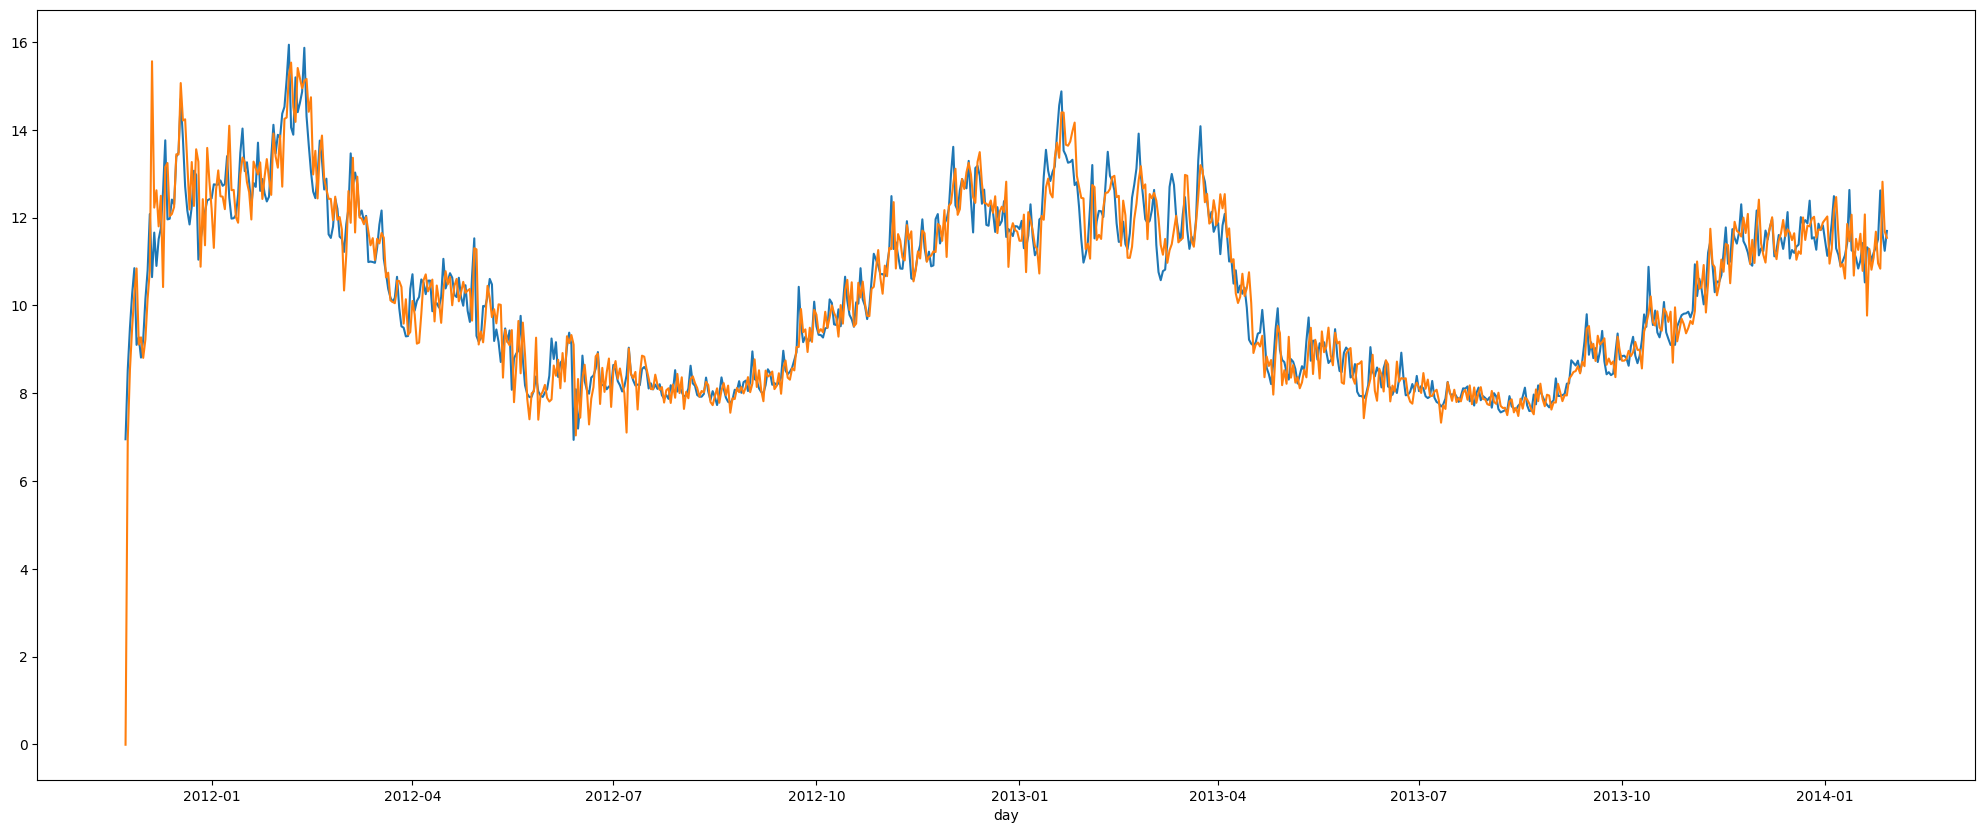

In [ ]:
train['avg_energy'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

In [ ]:
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test[['weather_cluster','holiday_ind']]))
test['predicted'] = predict.values
test.tail(5)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-48-551487712>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted'] = predict.values


,avg_energy,weather_cluster,holiday_ind,predicted
day,,,,
2014-02-23,11.382719,0,0,11.432007
2014-02-24,10.323391,0,0,10.640311
2014-02-25,10.199254,0,0,11.377141
2014-02-26,10.115615,0,0,11.786270
2014-02-27,10.261822,0,0,11.430807


In [ ]:
test['residual'] = abs(test['avg_energy']-test['predicted'])
MAE = test['residual'].sum()/len(test)
MAPE = (abs(test['residual'])/test['avg_energy']).sum()*100/len(test)
print("MAE:", MAE)
print("MAPE:", MAPE)

MAE: 0.6249302610221953
MAPE: 5.771758687031262


<ipython-input-49-2334414777>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['residual'] = abs(test['avg_energy']-test['predicted'])


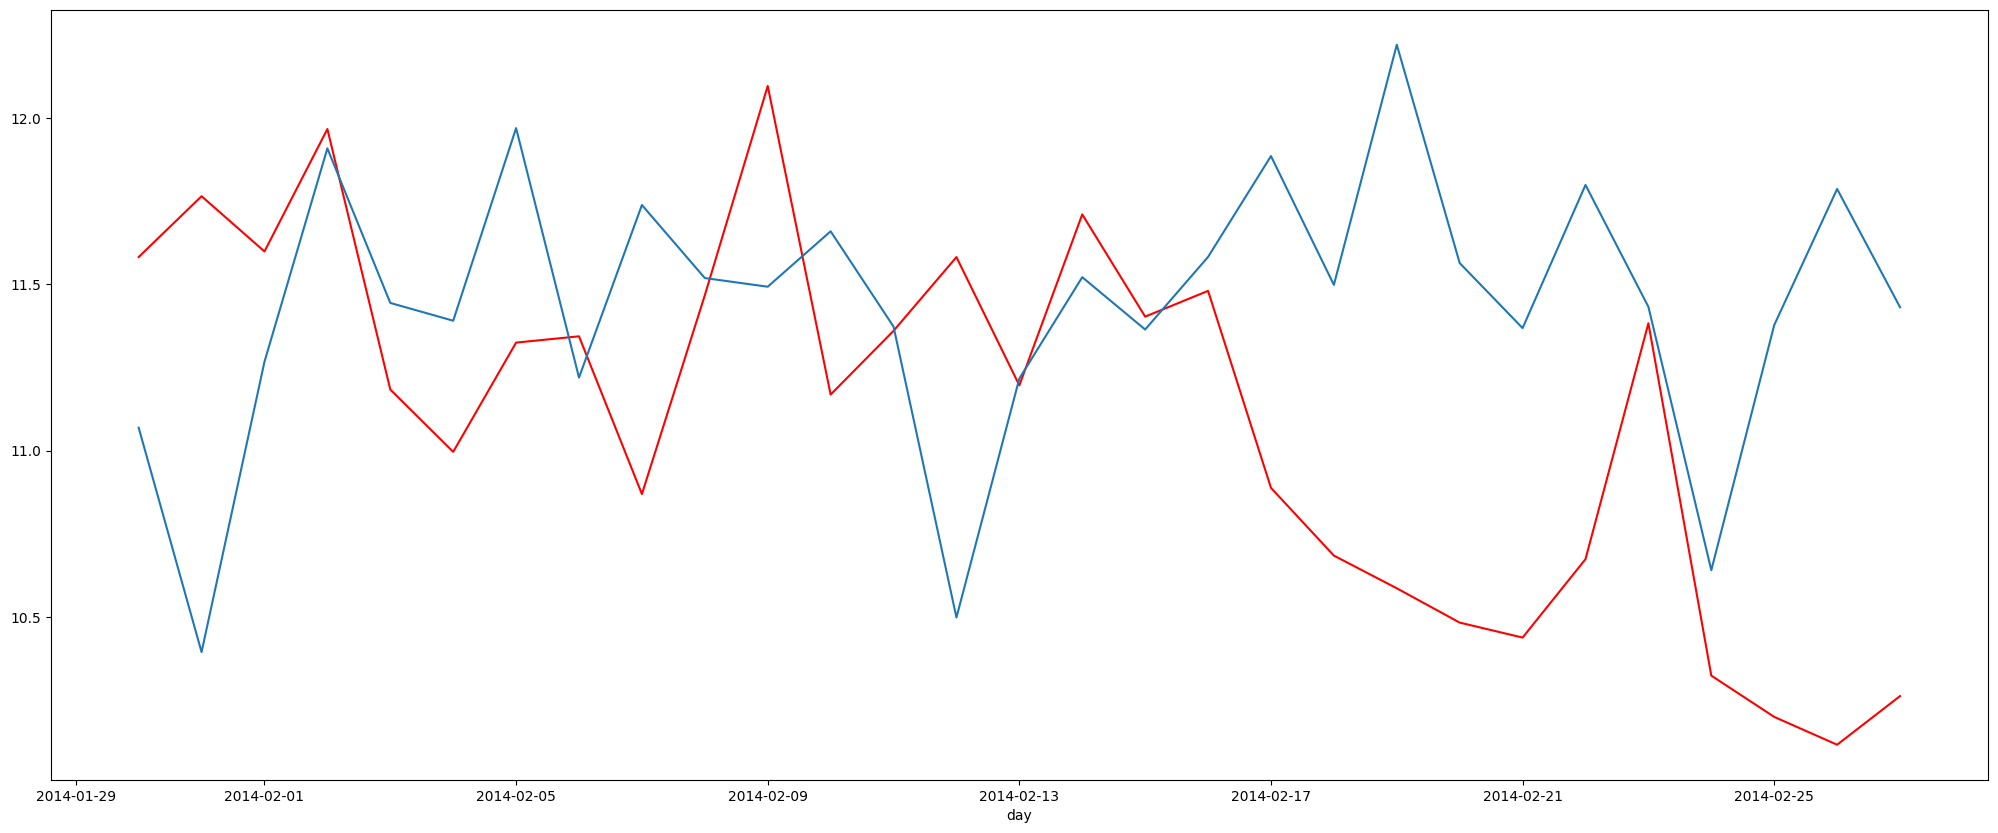

In [ ]:
test['avg_energy'].plot(figsize=(25,10),color = 'red')
test['predicted'].plot()
plt.show()

<Axes: xlabel='day'>

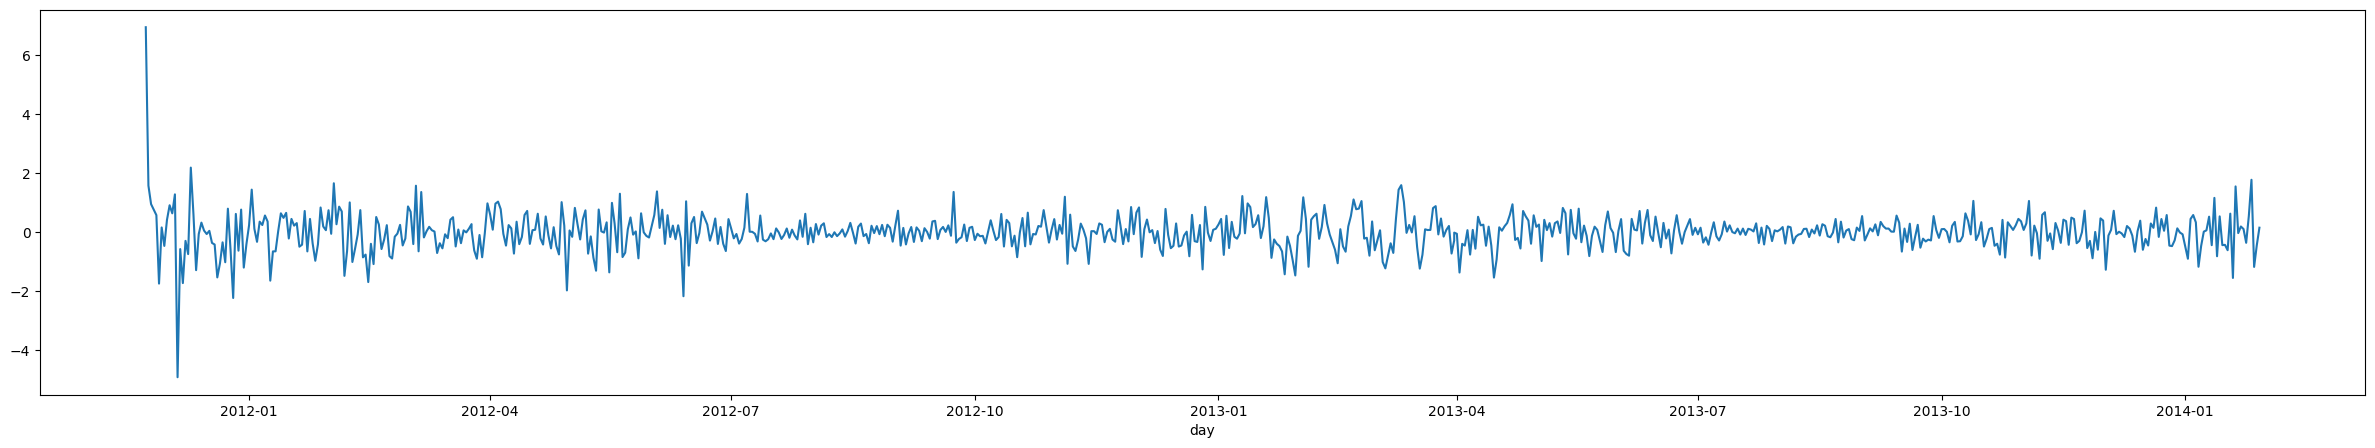

In [ ]:
model_fit.resid.plot(figsize= (30,5))

<Axes: xlabel='day'>

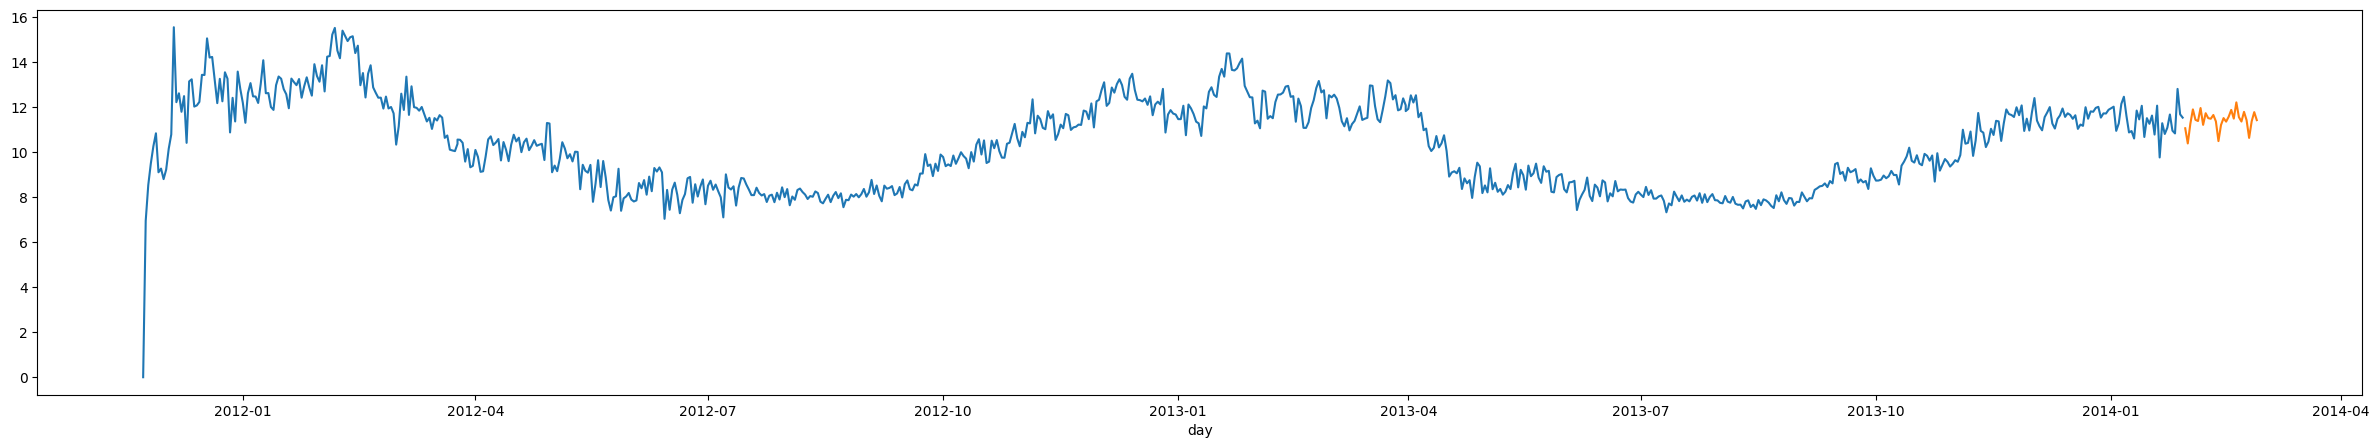

In [ ]:
model_fit.fittedvalues.plot(figsize = (30,5))
test.predicted.plot()

In [ ]:
test['predicted'].tail(5)

,predicted
day,
2014-02-23,11.432007
2014-02-24,10.640311
2014-02-25,11.377141
2014-02-26,11.786270
2014-02-27,11.430807


## **LSTM**

In [ ]:
np.random.seed(11)
dataframe = weather_energy.loc[:,'avg_energy']
dataset = dataframe.values
dataset = dataset.astype('float32')

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
reframed = series_to_supervised(dataset, 7,1)
reframed.head(3)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,6.952693,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513
8,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707
9,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707,10.145910


In [ ]:
reframed['weather_cluster'] = weather_energy.weather_cluster.values[7:]
reframed['holiday_ind']= weather_energy.holiday_ind.values[7:]

In [ ]:
reframed = reframed.reindex(['weather_cluster', 'holiday_ind','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'], axis=1)
reframed = reframed.values

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)

In [ ]:
# split into train and test sets
train = reframed[:(len(reframed)-30), :]
test = reframed[(len(reframed)-30):len(reframed), :]

In [ ]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(791, 1, 9) (791,) (30, 1, 9) (30,)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 3s - 237ms/step - loss: 0.5512
Epoch 2/50
11/11 - 0s - 6ms/step - loss: 0.4242
Epoch 3/50
11/11 - 0s - 6ms/step - loss: 0.2861
Epoch 4/50
11/11 - 0s - 13ms/step - loss: 0.1477
Epoch 5/50
11/11 - 0s - 6ms/step - loss: 0.1118
Epoch 6/50
11/11 - 0s - 6ms/step - loss: 0.1101
Epoch 7/50
11/11 - 0s - 6ms/step - loss: 0.0996
Epoch 8/50
11/11 - 0s - 6ms/step - loss: 0.0904
Epoch 9/50
11/11 - 0s - 6ms/step - loss: 0.0830
Epoch 10/50
11/11 - 0s - 13ms/step - loss: 0.0756
Epoch 11/50
11/11 - 0s - 6ms/step - loss: 0.0686
Epoch 12/50
11/11 - 0s - 13ms/step - loss: 0.0617
Epoch 13/50
11/11 - 0s - 6ms/step - loss: 0.0552
Epoch 14/50
11/11 - 0s - 6ms/step - loss: 0.0491
Epoch 15/50
11/11 - 0s - 15ms/step - loss: 0.0436
Epoch 16/50
11/11 - 0s - 11ms/step - loss: 0.0386
Epoch 17/50
11/11 - 0s - 8ms/step - loss: 0.0345
Epoch 18/50
11/11 - 0s - 12ms/step - loss: 0.0312
Epoch 19/50
11/11 - 0s - 6ms/step - loss: 0.0289
Epoch 20/50
11/11 - 0s - 13ms/step - loss: 0.0278
Epoch 21/50
11/11 - 0s - 6ms/st

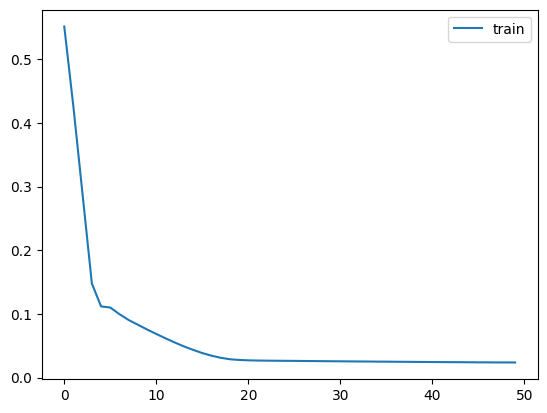

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


In [ ]:
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])

In [ ]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [ ]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)

In [ ]:
act = [i[9] for i in inv_y] # last element is the predicted average energy
pred = [i[9] for i in inv_yhat] # last element is the actual average energy

# calculate RMSE
import math
rmse = math.sqrt(mean_squared_error(act, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.000


Test RMSE is 0.0, that's a red flag — **so we need to inverse scaling or indexing logic.**

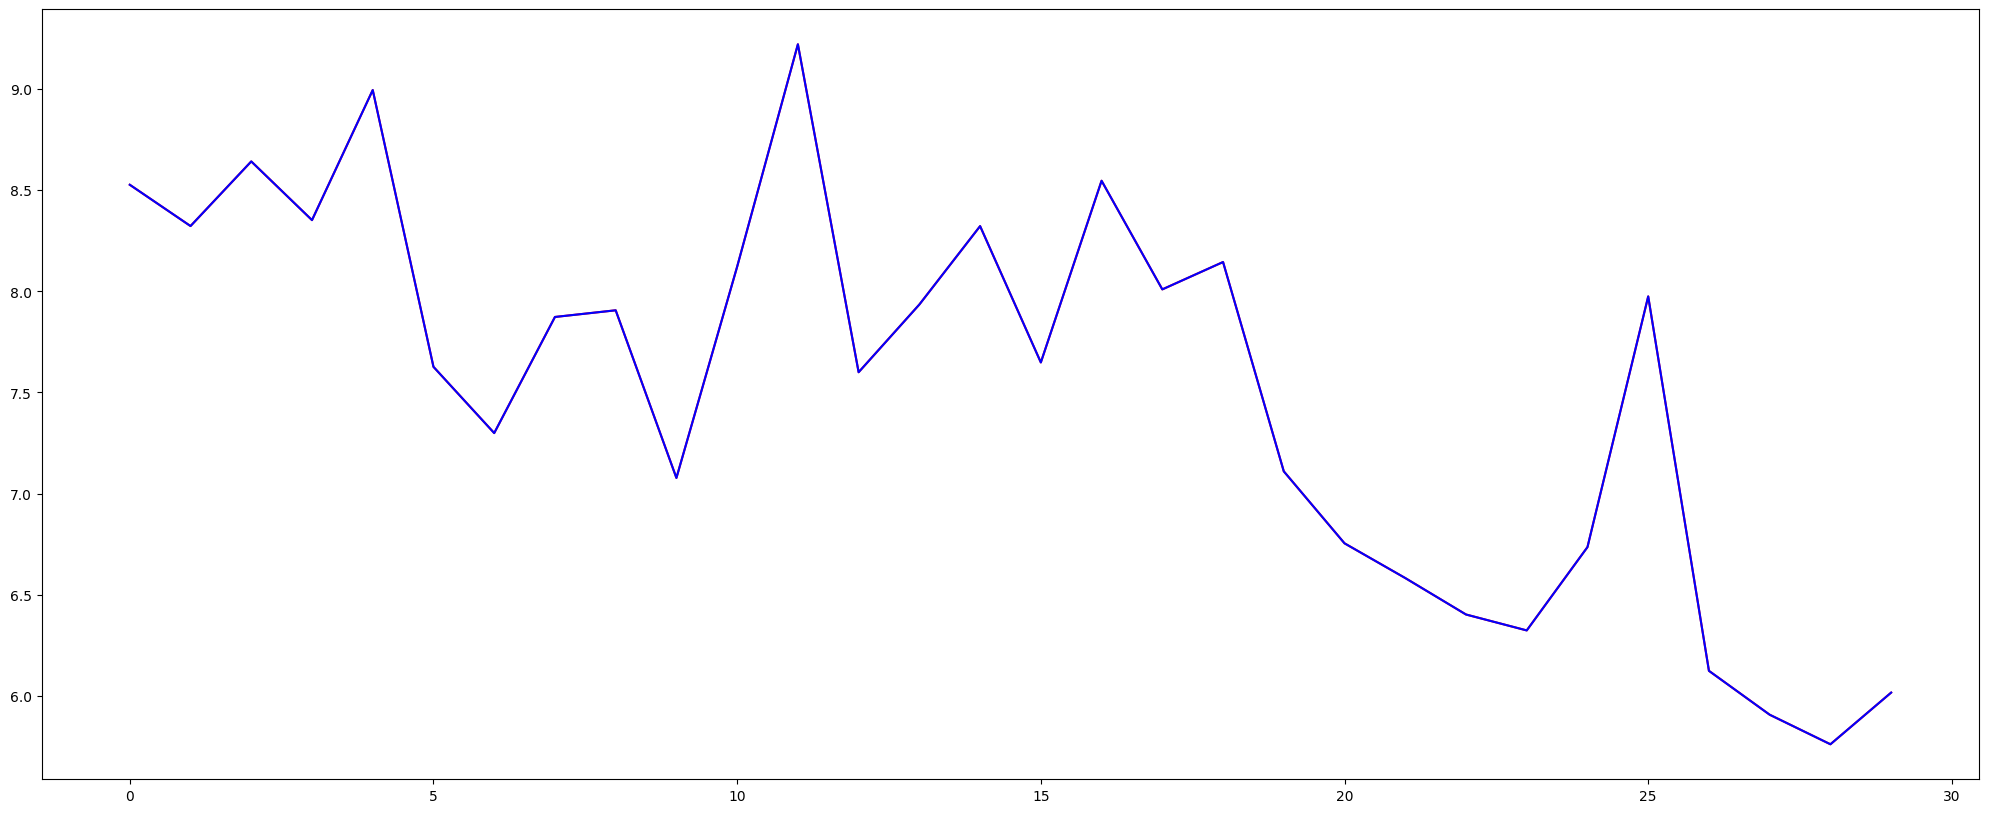

In [ ]:
predicted_lstm = pd.DataFrame({'predicted':pred,'avg_energy':act})
predicted_lstm['avg_energy'].plot(figsize=(25,10),color = 'red')
predicted_lstm['predicted'].plot(color = 'blue')
plt.show()

In [ ]:
# invert scaling for forecast
inv_yhat = np.concatenate((test_X, yhat), axis=1)  # yhat is added at the end
inv_yhat = scaler.inverse_transform(inv_yhat)
pred = inv_yhat[:, -1]  # last column is the prediction

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X, test_y), axis=1)  # test_y is added at the end
inv_y = scaler.inverse_transform(inv_y)
act = inv_y[:, -1]  # last column is the actual avg_energy

# calculate RMSE
from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt(mean_squared_error(act, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.894


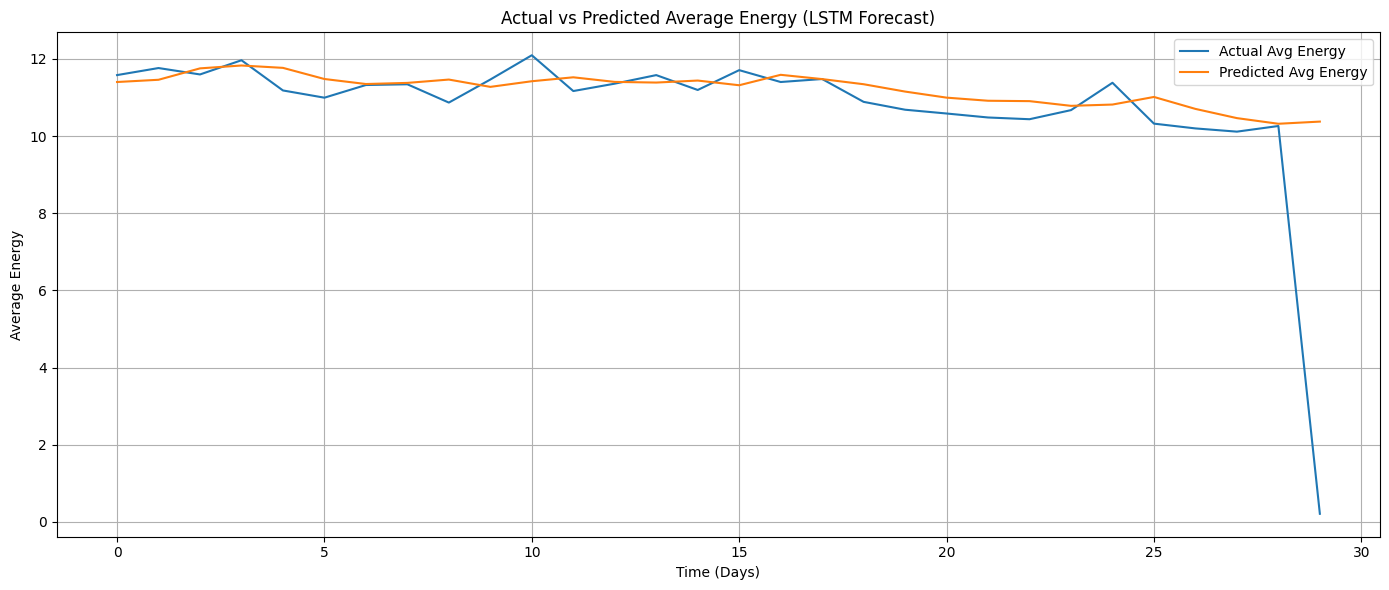

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(act, label='Actual Avg Energy', color='tab:blue')
plt.plot(pred, label='Predicted Avg Energy', color='tab:orange')
plt.title('Actual vs Predicted Average Energy (LSTM Forecast)')
plt.xlabel('Time (Days)')
plt.ylabel('Average Energy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

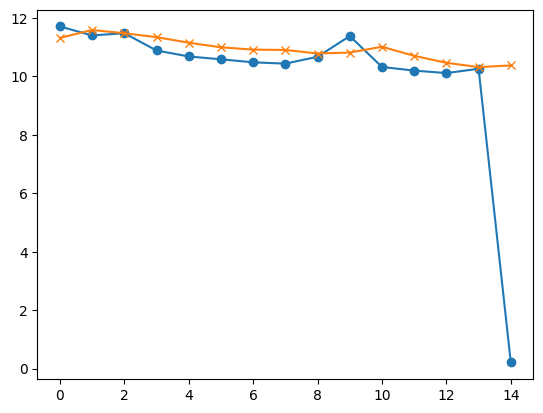

In [ ]:
plt.plot(act[-15:], label='Actual', marker='o')
plt.plot(pred[-15:], label='Predicted', marker='x')

The predicted value doesn’t follow this sharp drop — it stays stable, which is why there's a gap between the actual and predicted in that point.

In [ ]:
last_value = act[-1]
print(f"Last actual value: {last_value}")

Last actual value: 0.2079789638519287


In [ ]:
mean_val = np.mean(act[:-1])
std_val = np.std(act[:-1])
print(f"Mean: {mean_val}, Std Dev: {std_val}")

Mean: 11.107687128001245, Std Dev: 0.5429606955486929


In [ ]:
z_score = (last_value - mean_val) / std_val
print(f"Z-score of last value: {z_score}")

Z-score of last value: -20.074580450311487


In [ ]:
if abs(z_score) > 2:
    print(" Anomaly Detected: Last value is statistically unusual!")
else:
    print(" Last value is within normal range.")

⚠️ Anomaly Detected: Last value is statistically unusual!


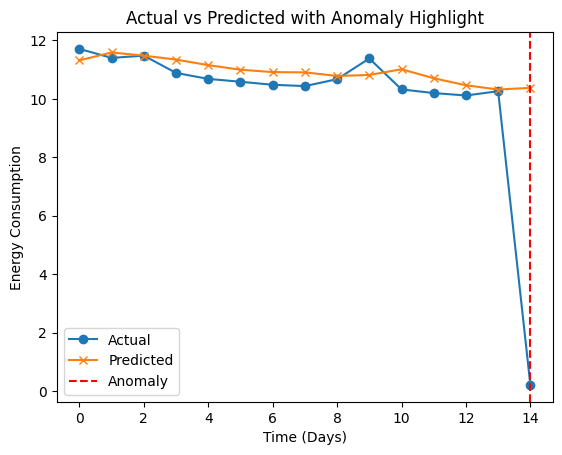

In [ ]:
plt.plot(act[-15:], label='Actual', marker='o')
plt.plot(pred[-15:], label='Predicted', marker='x')
plt.axvline(x=14, color='red', linestyle='--', label='Anomaly')
plt.legend()
plt.title('Actual vs Predicted with Anomaly Highlight')
plt.xlabel('Time (Days)')
plt.ylabel('Energy Consumption')
plt.show()

In [ ]:
weather_energy['anomaly'] = 0
weather_energy.loc[weather_energy.index[-1], 'anomaly'] = 1

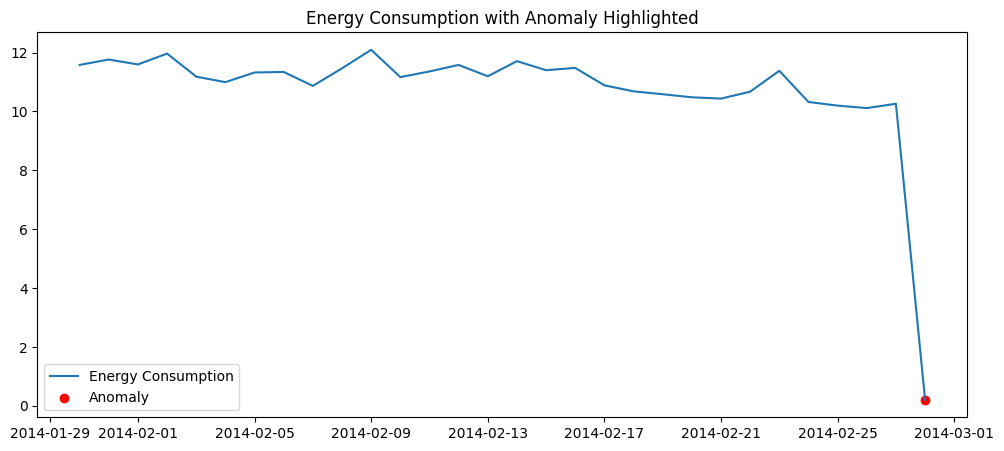

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(weather_energy['avg_energy'][-30:], label='Energy Consumption')
plt.scatter(weather_energy[weather_energy['anomaly'] == 1].index,
            weather_energy[weather_energy['anomaly'] == 1]['avg_energy'],
            color='red', label='Anomaly')
plt.legend()
plt.title("Energy Consumption with Anomaly Highlighted")
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Convert to numpy arrays if not already
actual = np.array(act)
predicted = np.array(pred)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(actual, predicted)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(actual, predicted))

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

# R-squared Score (Coefficient of Determination)
r2 = r2_score(actual, predicted)

# Print all scores
print(f"Evaluation Metrics:")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.3f}")


Evaluation Metrics:
MAE  : 0.649
RMSE : 1.894
MAPE : 165.79%
R²   : 0.128


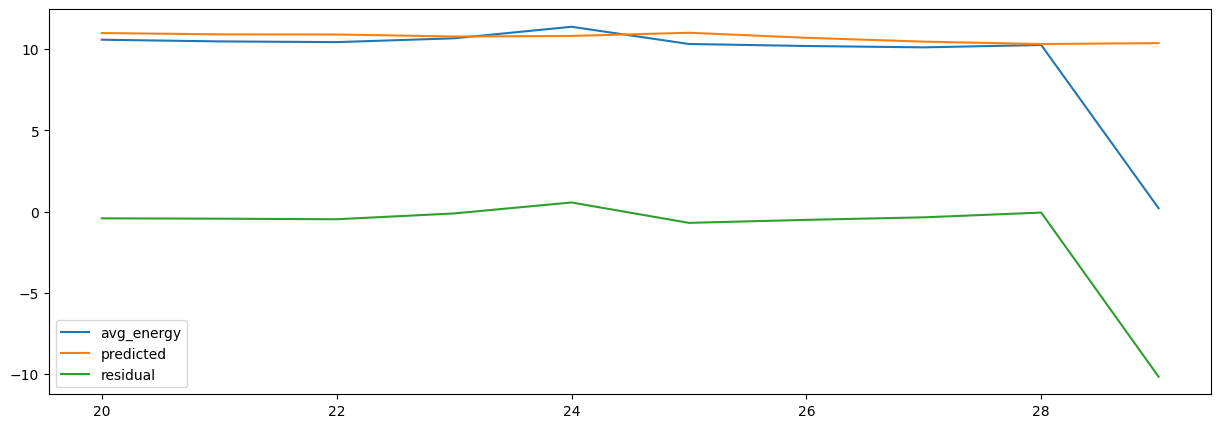

In [ ]:
test_df = pd.DataFrame({'avg_energy': act}) # 'act' contains the actual values

# Add the predicted values to the DataFrame
test_df['predicted'] = pred # 'pred' contains the predicted values from the LSTM model

# Calculate the residual
test_df['residual'] = test_df['avg_energy'] - test_df['predicted']

# Plot the last 10 values
test_df[['avg_energy', 'predicted', 'residual']].tail(10).plot(figsize=(15,5))
plt.show() # Add this to display the plot

In [ ]:
# Prepare energy data
energy['day'] = pd.to_datetime(energy['day']).dt.date
housecount = energy.groupby('day')[['LCLid']].nunique()
energy = energy.groupby('day')[['energy_sum']].sum().merge(housecount, on='day').reset_index()
energy['avg_energy'] = energy['energy_sum'] / energy['LCLid']

# Prepare weather data
# Reload the weather data to ensure the 'time' column is present
weather = pd.read_csv('/content/extracted_data/weather_daily_darksky.csv')
# Remove unit='s' as the time column appears to be a string date, not a Unix timestamp
weather['day'] = pd.to_datetime(weather['time']).dt.date
# Selecting necessary columns *after* processing the 'time' column
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day']]
weather.dropna(inplace=True)

# Merge energy and weather
weather_energy = energy.merge(weather, on='day')

# Add holiday indicator
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays']).dt.date
weather_energy = weather_energy.merge(holiday, left_on='day', right_on='Bank holidays', how='left')
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(), 0, 1)

# Add year, month and set index
weather_energy['Year'] = pd.DatetimeIndex(weather_energy['day']).year
weather_energy['Month'] = pd.DatetimeIndex(weather_energy['day']).month
weather_energy.set_index('day', inplace=True)

In [ ]:
from sklearn.cluster import KMeans

# Select and scale weather variables
weather_scaled = weather_energy[['temperatureMax','dewPoint', 'cloudCover', 'windSpeed',
                                 'pressure', 'visibility', 'humidity','uvIndex', 'moonPhase']]
scaler_w = MinMaxScaler()
weather_scaled = scaler_w.fit_transform(weather_scaled)

# Fit KMeans
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm='lloyd', random_state=42)
weather_energy['weather_cluster'] = kmeans.fit_predict(weather_scaled)

In [ ]:
# Convert time series to supervised format
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    df = pd.DataFrame(data)
    cols, names = list(), []
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'var1(t-{i})']
    for i in range(n_out):
        cols.append(df.shift(-i))
        names += [f'var1(t+{i})'] if i != 0 else [f'var1(t)']
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Prepare dataset
dataframe = weather_energy['avg_energy']
dataset = dataframe.values.astype('float32')
reframed = series_to_supervised(dataset, 7, 1)
reframed['weather_cluster'] = weather_energy.weather_cluster.values[7:]
reframed['holiday_ind'] = weather_energy.holiday_ind.values[7:]

# Reorder columns
reframed = reframed.reindex(['weather_cluster', 'holiday_ind',
                             'var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)',
                             'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'var1(t)'], axis=1)
reframed = reframed.values

In [ ]:
scaler = MinMaxScaler()
reframed = scaler.fit_transform(reframed)

train = reframed[:(len(reframed)-30), :]
test = reframed[(len(reframed)-30):, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape for LSTM
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 5s - 419ms/step - loss: 0.4431
Epoch 2/50
11/11 - 0s - 28ms/step - loss: 0.2943
Epoch 3/50
11/11 - 0s - 9ms/step - loss: 0.1512
Epoch 4/50
11/11 - 0s - 12ms/step - loss: 0.0489
Epoch 5/50
11/11 - 0s - 12ms/step - loss: 0.0547
Epoch 6/50
11/11 - 0s - 7ms/step - loss: 0.0501
Epoch 7/50
11/11 - 0s - 6ms/step - loss: 0.0396
Epoch 8/50
11/11 - 0s - 6ms/step - loss: 0.0373
Epoch 9/50
11/11 - 0s - 6ms/step - loss: 0.0327
Epoch 10/50
11/11 - 0s - 6ms/step - loss: 0.0306
Epoch 11/50
11/11 - 0s - 6ms/step - loss: 0.0279
Epoch 12/50
11/11 - 0s - 6ms/step - loss: 0.0260
Epoch 13/50
11/11 - 0s - 13ms/step - loss: 0.0242
Epoch 14/50
11/11 - 0s - 13ms/step - loss: 0.0229
Epoch 15/50
11/11 - 0s - 13ms/step - loss: 0.0220
Epoch 16/50
11/11 - 0s - 13ms/step - loss: 0.0216
Epoch 17/50
11/11 - 0s - 13ms/step - loss: 0.0213
Epoch 18/50
11/11 - 0s - 12ms/step - loss: 0.0213
Epoch 19/50
11/11 - 0s - 6ms/step - loss: 0.0212
Epoch 20/50
11/11 - 0s - 6ms/step - loss: 0.0211
Epoch 21/50
11/11 - 0s - 6ms/

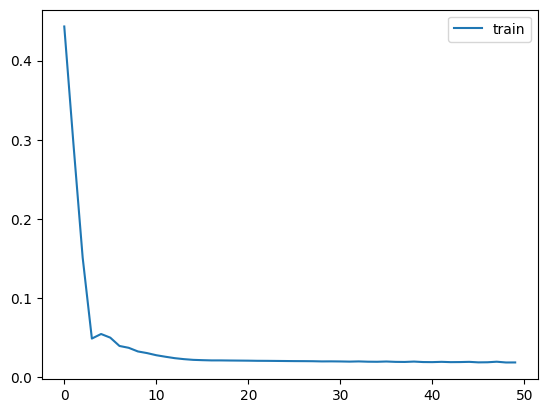

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Train
history = model.fit(train_X, train_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [ ]:
# Predict
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert scaling
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
pred = inv_yhat[:, -1]

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
actual = inv_y[:, -1]

# Evaluation
rmse = np.sqrt(mean_squared_error(actual, pred))
r2 = r2_score(actual, pred)

print(f'RMSE: {rmse:.3f}')
print(f'R² Score: {r2:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
✅ RMSE: 0.000
✅ R² Score: 1.000
